# Taller 6: Unsupervised Learning ❤️‍🔥
---

<div class="alert alert-block alert-danger">
<b> Integrantes:</b> &nbsp; Daniel Andrade, Gabriel Cubides, Dewith Miramón & Santiago Prado<br>
</div>

Benito Antonio Martínez Ocasio, mejor conocido como **Bad Bunny**, es un rapero y compositor puertorriqueño, su música ha sonado en los últimos años siendo uno de los artistas más sonados en el mundo. 

Con el objetivo de que más personas conozcan la discografía de este gran artista, creamos un sistema de segmentación de sus canciones basados en características del audio y de las letras. Así, las personas podrán escuchar solo las canciones de Benito de pertenezcan al género del reggaetón y que no sean explicitas, por ejemplo.


<div style="text-align:left">
<img src="https://phantom-marca.unidadeditorial.es/1b094c27f2d1c358d630e739cfc170f0/resize/1320/f/jpg/assets/multimedia/imagenes/2022/05/06/16518738119183.jpg" alt="Quién es Bad Bunny: su vida, carrera, canciones más exitosas y por qué es un fenómeno popular" width="800"/>
</div>
<sup>
Foto obtenida de <a href="https://www.marca.com/claro-mx/trending/2022/05/07/6275985b46163f53688b45c4.html">MARCA</a>
</sup>

In [ ]:
# Utils
import re
import json
import yaml
import pprint as pp
import importlib
import urllib
import time 
from thefuzz import fuzz
from thefuzz import process
import textwrap as tw

# Data
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
import vapeplot
import dufte
plt.style.use(dufte.style)
vapeplot.set_palette('jazzcup')
palette = vapeplot.palette("jazzcup")

# Spotify
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotify_functions import offset_api_limit

# Genius
import genius_functions as genius
importlib.reload(genius)

# Scraping
import requests
import urllib.request
import urllib.parse
from bs4 import BeautifulSoup

# Models
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from pysentimiento import create_analyzer

## Creación del dataset 💽

### Característica del audio 🎼

In [ ]:
with open("spotify/spotify_details.yml", 'r') as stream:
    spotify_details = yaml.safe_load(stream)

In [ ]:
# https://developer.spotify.com/web-api/using-scopes/
scope = "user-library-read user-follow-read user-top-read playlist-read-private"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=spotify_details['SPOTIPY_CLIENT_ID'],
    client_secret=spotify_details['SPOTIPY_CLIENT_SECRET'],
    redirect_uri=spotify_details['SPOTIPY_REDIRECT_URI'],
    scope=scope,
))

In [ ]:
badbunny_uri = 'spotify:artist:4q3ewBCX7sLwd24euuV69X'
artist = sp.artist(badbunny_uri)
albums = offset_api_limit(sp, sp.artist_albums(artist_id=badbunny_uri, 
                                               album_type=['album', 'single'],
                                               country=None, 
                                               limit=20))
 
pp.pprint(artist)

{'external_urls': {'spotify': 'https://open.spotify.com/artist/4q3ewBCX7sLwd24euuV69X'},
 'followers': {'href': None, 'total': 50650663},
 'genres': ['latin', 'reggaeton', 'trap latino'],
 'href': 'https://api.spotify.com/v1/artists/4q3ewBCX7sLwd24euuV69X',
 'id': '4q3ewBCX7sLwd24euuV69X',
 'images': [{'height': 640,
             'url': 'https://i.scdn.co/image/ab6761610000e5eb8ee9a6f54dcbd4bc95126b14',
             'width': 640},
            {'height': 320,
             'url': 'https://i.scdn.co/image/ab676161000051748ee9a6f54dcbd4bc95126b14',
             'width': 320},
            {'height': 160,
             'url': 'https://i.scdn.co/image/ab6761610000f1788ee9a6f54dcbd4bc95126b14',
             'width': 160}],
 'name': 'Bad Bunny',
 'popularity': 100,
 'type': 'artist',
 'uri': 'spotify:artist:4q3ewBCX7sLwd24euuV69X'}


In [ ]:
df_albums = pd.DataFrame(columns=['album_name', 'artists', 'total_tracks',
                                  'album_url', 'cover_url', 'album_uri'])
for i, album in enumerate(albums['items']):
    df_albums.loc[i] = {
        'album_name': album['name'],
        'artists': ', '.join(art['name'] for art in album['artists']),
        'total_tracks': album['total_tracks'], 
        'album_url': album['external_urls']['spotify'],
        'cover_url': album['name'],
        'album_uri': album['uri']
    }

In [ ]:
df_albums

,album_name,artists,total_tracks,album_url,cover_url,album_uri
0,Un Verano Sin Ti,Bad Bunny,23,https://open.spotify.com/album/3RQQmkQEvNCY4pr...,Un Verano Sin Ti,spotify:album:3RQQmkQEvNCY4prGKE6oc5
1,EL ÚLTIMO TOUR DEL MUNDO,Bad Bunny,16,https://open.spotify.com/album/2d9BCZeAAhiZWPp...,EL ÚLTIMO TOUR DEL MUNDO,spotify:album:2d9BCZeAAhiZWPpbX9aPCW
2,LAS QUE NO IBAN A SALIR,Bad Bunny,10,https://open.spotify.com/album/4gvQO5mEuhbMSrL...,LAS QUE NO IBAN A SALIR,spotify:album:4gvQO5mEuhbMSrLIuwXkmz
3,YHLQMDLG,Bad Bunny,20,https://open.spotify.com/album/5lJqux7orBlA1Qz...,YHLQMDLG,spotify:album:5lJqux7orBlA1QzyiBGti1
4,OASIS,"J Balvin, Bad Bunny",8,https://open.spotify.com/album/6ylFfzx32ICw4L1...,OASIS,spotify:album:6ylFfzx32ICw4L1A7YWNLN
5,X 100PRE,Bad Bunny,15,https://open.spotify.com/album/7CjJb2mikwAWA1V...,X 100PRE,spotify:album:7CjJb2mikwAWA1V6kewFBF


In [ ]:
df_tracks = pd.DataFrame(columns=['song_name', 'song_artists', 'song_duration', 
                                  'song_is_explicit', 'song_url', 
                                  'song_preview_url', 'song_uri', 
                                  'album_uri'])

i = 0
for idx, row in df_albums.iterrows():
    album_uri = row['album_uri']
    album_tracks = offset_api_limit(
        sp, sp.album_tracks(album_id=album_uri, 
                            limit=50, offset=0, market=None)
    )
    for track in album_tracks:
        df_tracks.loc[i] = {
            'song_name': track['name'],
            'song_artists': ', '.join(art['name'] for art in track['artists']),
            'song_duration': (track['duration_ms']/1000)/60,
            'song_is_explicit': track['explicit'],
            'song_url': track['external_urls']['spotify'],
            'song_preview_url': track['preview_url'],
            'song_uri': track['uri'],
            'album_uri': album_uri
        }
        i += 1

df_tracks['audio_features'] = sp.audio_features(list(df_tracks['song_uri'].values))
df_tracks = df_tracks.drop('audio_features', axis=1).assign(**df_tracks['audio_features'].apply(pd.Series))
drop_cols = ['type', 'id', 'uri', 'track_href', 'analysis_url', 
             'duration_ms', 'time_signature']
df_tracks.drop(columns=drop_cols, inplace=True)

In [ ]:
df_audio =  pd.merge(df_albums, df_tracks, how='left', on='album_uri')

In [ ]:
df_audio.sample(5)

,album_name,artists,total_tracks,album_url,cover_url,album_uri,song_name,song_artists,song_duration,song_is_explicit,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
49,YHLQMDLG,Bad Bunny,20,https://open.spotify.com/album/5lJqux7orBlA1Qz...,YHLQMDLG,spotify:album:5lJqux7orBlA1QzyiBGti1,Si Veo a Tu Mamá,Bad Bunny,2.849517,False,...,0.603,2,-5.313,1,0.0646,0.4020,0.000005,0.134,0.824,129.928
14,Un Verano Sin Ti,Bad Bunny,23,https://open.spotify.com/album/3RQQmkQEvNCY4pr...,Un Verano Sin Ti,spotify:album:3RQQmkQEvNCY4prGKE6oc5,Dos Mil 16,Bad Bunny,3.476917,False,...,0.670,1,-6.534,1,0.0506,0.1230,0.000002,0.128,0.495,130.058
42,LAS QUE NO IBAN A SALIR,Bad Bunny,10,https://open.spotify.com/album/4gvQO5mEuhbMSrL...,LAS QUE NO IBAN A SALIR,spotify:album:4gvQO5mEuhbMSrLIuwXkmz,CANCIÓN CON YANDEL,"Yandel, Bad Bunny",3.486333,True,...,0.741,9,-4.430,1,0.4020,0.4470,0.000000,0.121,0.495,79.968
20,Un Verano Sin Ti,Bad Bunny,23,https://open.spotify.com/album/3RQQmkQEvNCY4pr...,Un Verano Sin Ti,spotify:album:3RQQmkQEvNCY4prGKE6oc5,Un Verano Sin Ti,Bad Bunny,2.469050,False,...,0.496,5,-9.123,0,0.0556,0.6930,0.000000,0.123,0.412,187.844
35,EL ÚLTIMO TOUR DEL MUNDO,Bad Bunny,16,https://open.spotify.com/album/2d9BCZeAAhiZWPp...,EL ÚLTIMO TOUR DEL MUNDO,spotify:album:2d9BCZeAAhiZWPpbX9aPCW,SORRY PAPI,"Bad Bunny, ABRA",2.717550,True,...,0.561,1,-6.054,1,0.0851,0.0601,0.000000,0.145,0.393,191.911


### Características de la letra ✒️

In [ ]:
artist_name = 'Bad Bunny'
results = genius.search_artist(artist_name)

Cardi B, Bad Bunny & J Balvin: I Like It
Nio García, Casper Mágico & Bad Bunny: Te Boté (Remix)
Bad Bunny: Amorfoda
Bad Bunny: Tú No Metes Cabra
Bad Bunny: MIA
Bad Bunny: Yonaguni
Bad Bunny, Jowell & Randy & Ñengo Flow: Safaera
Jhay Cortez, J Balvin & Bad Bunny: No Me Conoce (Remix)
Bad Bunny & Jhay Cortez: DÁKITI
Bad Bunny: Chambea


In [ ]:
pp.pprint(results[2]['result']['primary_artist'])

{'api_path': '/artists/690350',
 'header_image_url': 'https://images.genius.com/3f26c4ceeed73948eff37118e65d9c15.1000x403x1.jpg',
 'id': 690350,
 'image_url': 'https://images.genius.com/41835ceb7df4b2f4f04f5b77673fff7a.746x746x1.jpg',
 'is_meme_verified': False,
 'is_verified': False,
 'name': 'Bad Bunny',
 'url': 'https://genius.com/artists/Bad-bunny'}


In [ ]:
artist_id = results[2]['result']['primary_artist']['id']
artist_data = genius.get_artist(artist_id)

Followers: 1025


In [ ]:
%%time
songs_ids = genius.get_songs_ids(artist_id)

Page 2 finished scraping
Page 3 finished scraping
Page 4 finished scraping
Page 5 finished scraping
Page 6 finished scraping
Page 7 finished scraping
Page 8 finished scraping
Page 9 finished scraping
Page 10 finished scraping
Page 11 finished scraping
Page 12 finished scraping
Page 13 finished scraping
Page 14 finished scraping
Page 15 finished scraping
Page 16 finished scraping
Page 17 finished scraping
Page 18 finished scraping
Page 19 finished scraping
Page 20 finished scraping
Page 21 finished scraping
Song id were scraped from 21 pages
Wall time: 25.5 s


In [ ]:
len(songs_ids)

134

In [ ]:
df_audio.sample(5)

,album_name,artists,total_tracks,album_url,cover_url,album_uri,song_name,song_artists,song_duration,song_is_explicit,song_url,song_preview_url,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
58,YHLQMDLG,Bad Bunny,20,https://open.spotify.com/album/5lJqux7orBlA1Qz...,YHLQMDLG,spotify:album:5lJqux7orBlA1QzyiBGti1,Vete,Bad Bunny,3.200400,True,https://open.spotify.com/track/2n7ohqg1s68ToAH...,https://p.scdn.co/mp3-preview/c01b25252f655fef...,spotify:track:2n7ohqg1s68ToAHh4u9mcW,0.886,0.672,1,-4.394,1,0.1880,0.0363,0.000009,0.1010,0.526,91.976
71,OASIS,"J Balvin, Bad Bunny",8,https://open.spotify.com/album/6ylFfzx32ICw4L1...,OASIS,spotify:album:6ylFfzx32ICw4L1A7YWNLN,CUIDAO POR AHÍ,"J Balvin, Bad Bunny",3.305333,False,https://open.spotify.com/track/6SYSu569pfYdkDT...,https://p.scdn.co/mp3-preview/fa1e7a0435c8b099...,spotify:track:6SYSu569pfYdkDT9A5lZqi,0.845,0.813,4,-2.979,0,0.0770,0.1110,0.002410,0.1740,0.586,90.980
50,YHLQMDLG,Bad Bunny,20,https://open.spotify.com/album/5lJqux7orBlA1Qz...,YHLQMDLG,spotify:album:5lJqux7orBlA1QzyiBGti1,La Difícil,Bad Bunny,2.718067,True,https://open.spotify.com/track/6NfrH0ANGmgBXyx...,https://p.scdn.co/mp3-preview/9f0ba371413d258d...,spotify:track:6NfrH0ANGmgBXyxgV2PeXt,0.685,0.848,8,-4.561,0,0.0858,0.0861,0.000007,0.0783,0.761,179.870
76,OASIS,"J Balvin, Bad Bunny",8,https://open.spotify.com/album/6ylFfzx32ICw4L1...,OASIS,spotify:album:6ylFfzx32ICw4L1A7YWNLN,COMO UN BEBÉ,"J Balvin, Bad Bunny, Mr Eazi",3.647100,False,https://open.spotify.com/track/7knLcYCOSaURD0d...,https://p.scdn.co/mp3-preview/201221bbf3320178...,spotify:track:7knLcYCOSaURD0d7HUULFM,0.825,0.807,6,-5.753,1,0.0949,0.0732,0.000005,0.1380,0.816,103.053
41,LAS QUE NO IBAN A SALIR,Bad Bunny,10,https://open.spotify.com/album/4gvQO5mEuhbMSrL...,LAS QUE NO IBAN A SALIR,spotify:album:4gvQO5mEuhbMSrLIuwXkmz,BYE ME FUI,Bad Bunny,2.966667,True,https://open.spotify.com/track/0FktnzDqjClqU6i...,https://p.scdn.co/mp3-preview/19d2b4b72f5cb2be...,spotify:track:0FktnzDqjClqU6iqOZVEs2,0.712,0.599,5,-6.342,0,0.1120,0.4120,0.000022,0.1030,0.588,179.788


In [ ]:
def get_genius_id(song_name, songs_ids):
    song_distances = []
    for genius_name, genius_id in songs_ids:
        distance = fuzz.ratio(song_name, genius_name)
        song_distances.append((genius_name, genius_id, distance))
    song_distances = sorted(song_distances, 
                            key=lambda x: x[2], 
                            reverse=True)
    id_most_similar = song_distances[0][1]
    print(f'{song_name} -> {song_distances[0][0]}')
    return id_most_similar

In [ ]:
df_audio['genius_id'] = df_audio['song_name'].apply(get_genius_id, 
                                                    songs_ids=songs_ids)

Moscow Mule -> Moscow Mule
Después de la Playa -> Después de la Playa
Me Porto Bonito -> Me Porto Bonito
Tití Me Preguntó -> Tití Me Preguntó
Un Ratito -> Un Ratito
Yo No Soy Celoso -> Yo No Soy Celoso
Tarot -> Tarot
Neverita -> Neverita
La Corriente -> La Corriente
Efecto -> Efecto
Party -> Party
Aguacero -> Aguacero
Enséñame a Bailar -> Enséñame a Bailar
Ojitos Lindos -> Ojitos Lindos
Dos Mil 16 -> Dos Mil 16
El Apagón -> El Apagón
Otro Atardecer -> Otro Atardecer
Un Coco -> Un Coco
Andrea -> Andrea
Me Fui de Vacaciones -> Me Fui de Vacaciones
Un Verano Sin Ti -> Un Verano Sin Ti
Agosto -> Agosto
Callaita -> Callaita
EL MUNDO ES MÍO -> EL MUNDO ES MÍO
TE MUDASTE -> TE MUDASTE
HOY COBRÉ -> HOY COBRÉ
MALDITA POBREZA -> MALDITA POBREZA
LA NOCHE DE ANOCHE -> LA NOCHE DE ANOCHE
TE DESEO LO MEJOR -> TE DESEO LO MEJOR
YO VISTO ASÍ -> YO VISTO ASÍ
HACIENDO QUE ME AMAS -> HACIENDO QUE ME AMAS
BOOKER T -> BOOKER T
LA DROGA -> LA DROGA
DÁKITI -> DÁKITI
TRELLAS -> TRELLAS
SORRY PAPI -> SORRY PAP

In [ ]:
df_audio['lyrics'] = np.nan

In [ ]:
%%time
for i in df_audio.index:
    if pd.isna(df_audio.at[i, 'lyrics']):
        df_audio.at[i, 'lyrics'] = genius.retrieve_lyrics(
            df_audio.at[i, 'genius_id'])
    else:
        continue

Moscow Mule --> [Letra de "Moscow Mule"]  [Intro]  Si yo no te escribo, tú no me escribe, ey  Si
Después de la Playa --> [Letra de "Después de la Playa"]  [Intro]  Yeah-yeah, yeah-yeah, yeah-yeah  Eh-e
Me Porto Bonito --> [Letra de "Me Porto Bonito"]  [Intro: Bad Bunny &   Chencho Corleone  ]  Yeah-ye
Tití Me Preguntó --> [Letra de "Tití Me Preguntó"]  [Intro: Bad Bunny]  Ey  [Coro: Bad Bunny]  Tití m
Un Ratito --> [Letra de "Un Ratito"]  [Intro]  Yeah-yeah-yeah-yeah  Yeah-yeah-yeah-yeah-yeah  
Yo No Soy Celoso --> [Letra de "Yo No Soy Celoso"]  [Intro]  Ey, ey  [Verso 1]  El que esté libre de 
Tarot --> [Letra de "Tarot"]  [Intro: Jhay Cortez]  Verte en el VIP de lejito e un privile
Neverita --> [Letra de "Neverita"]  [Coro]  Yo toy puesto pa ti y tú te me quita  Diablo, qué
La Corriente --> [Letra de "La Corriente"]  [Intro: Tony Dize]  La melodía con la calle  Tony Diz
Efecto --> [Letra de "Efecto"]  [Intro]  Yeah-yeah-yeah-yeah-yeah-yeah  Eh-eh-eh-eh  [Pre-C
Party --> [Letra de "Pa

In [ ]:
df_audio.sample(3)

,album_name,artists,total_tracks,album_url,cover_url,album_uri,song_name,song_artists,song_duration,song_is_explicit,song_url,song_preview_url,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genius_id,lyrics
30,EL ÚLTIMO TOUR DEL MUNDO,Bad Bunny,16,https://open.spotify.com/album/2d9BCZeAAhiZWPp...,EL ÚLTIMO TOUR DEL MUNDO,spotify:album:2d9BCZeAAhiZWPpbX9aPCW,HACIENDO QUE ME AMAS,Bad Bunny,3.629467,True,https://open.spotify.com/track/26QApq0cuO9brJi...,https://p.scdn.co/mp3-preview/de1744c8e5765007...,spotify:track:26QApq0cuO9brJigr0C0W4,0.584,0.411,10,-7.147,0,0.0838,0.869,0.000045,0.0955,0.412,169.934,6211030,"[Letra de ""HACIENDO QUE ME AMAS""] \n[Intro] \n..."
31,EL ÚLTIMO TOUR DEL MUNDO,Bad Bunny,16,https://open.spotify.com/album/2d9BCZeAAhiZWPp...,EL ÚLTIMO TOUR DEL MUNDO,spotify:album:2d9BCZeAAhiZWPpbX9aPCW,BOOKER T,Bad Bunny,2.607167,True,https://open.spotify.com/track/26w9NTiE9NGjW1Z...,https://p.scdn.co/mp3-preview/4a6875851497df08...,spotify:track:26w9NTiE9NGjW1ZvIOd1So,0.883,0.600,7,-7.188,1,0.3700,0.114,0.000008,0.0931,0.691,113.903,6250616,"[Letra de ""BOOKER T""] \n[Intro: Bad Bunny] \nE..."
43,LAS QUE NO IBAN A SALIR,Bad Bunny,10,https://open.spotify.com/album/4gvQO5mEuhbMSrL...,LAS QUE NO IBAN A SALIR,spotify:album:4gvQO5mEuhbMSrLIuwXkmz,PA' ROMPERLA,"Bad Bunny, Don Omar",3.236667,True,https://open.spotify.com/track/5XqCz18k96K8tx6...,https://p.scdn.co/mp3-preview/acbeb16d2a372881...,spotify:track:5XqCz18k96K8tx6DAYM97i,0.772,0.830,7,-5.019,1,0.0599,0.016,0.000000,0.0843,0.697,94.011,5529101,"[Letra de ""PA ROMPERLA""] \n[Intro: Bad Bunny] ..."


In [ ]:
df_audio.isna().sum()

album_name          0
artists             0
total_tracks        0
album_url           0
cover_url           0
album_uri           0
song_name           0
song_artists        0
song_duration       0
song_is_explicit    0
song_url            0
song_preview_url    1
song_uri            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genius_id           0
lyrics              0
dtype: int64

In [ ]:
df_audio.to_csv('data/df_songs.csv', index=False)

## Modelado 🤖

In [ ]:
df_songs = pd.read_csv('data/df_songs.csv')
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   album_name        92 non-null     object 
 1   artists           92 non-null     object 
 2   total_tracks      92 non-null     int64  
 3   album_url         92 non-null     object 
 4   cover_url         92 non-null     object 
 5   album_uri         92 non-null     object 
 6   song_name         92 non-null     object 
 7   song_artists      92 non-null     object 
 8   song_duration     92 non-null     float64
 9   song_is_explicit  92 non-null     bool   
 10  song_url          92 non-null     object 
 11  song_preview_url  91 non-null     object 
 12  song_uri          92 non-null     object 
 13  danceability      92 non-null     float64
 14  energy            92 non-null     float64
 15  key               92 non-null     int64  
 16  loudness          92 non-null     float64
 17 

In [ ]:
df_songs.sample(5)

,album_name,artists,total_tracks,album_url,cover_url,album_uri,song_name,song_artists,song_duration,song_is_explicit,song_url,song_preview_url,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genius_id,lyrics
73,OASIS,"J Balvin, Bad Bunny",8,https://open.spotify.com/album/6ylFfzx32ICw4L1...,OASIS,spotify:album:6ylFfzx32ICw4L1A7YWNLN,LA CANCIÓN,"J Balvin, Bad Bunny",4.042883,False,https://open.spotify.com/track/0fea68AdmYNygeT...,https://p.scdn.co/mp3-preview/a15a69bc0509eaa4...,spotify:track:0fea68AdmYNygeTGI4RC18,0.754,0.646,7,-5.795,1,0.3170,0.1520,0.000018,0.1080,0.429,176.089,3968305,"[Letra de ""LA CANCIÓN""] \n[Intro: Bad Bunny] \..."
91,X 100PRE,Bad Bunny,15,https://open.spotify.com/album/7CjJb2mikwAWA1V...,X 100PRE,spotify:album:7CjJb2mikwAWA1V6kewFBF,MIA,"Bad Bunny, Drake",3.506117,False,https://open.spotify.com/track/3gE4eQH3K83Sght...,https://p.scdn.co/mp3-preview/ad965cf8980111d6...,spotify:track:3gE4eQH3K83Sght0ZLvuBK,0.816,0.538,6,-6.354,0,0.0617,0.0142,0.000496,0.0990,0.156,97.054,3075944,"[Letra de ""MÍA"" ft. Drake] \n[Intro: Bad Bunny..."
48,LAS QUE NO IBAN A SALIR,Bad Bunny,10,https://open.spotify.com/album/4gvQO5mEuhbMSrL...,LAS QUE NO IBAN A SALIR,spotify:album:4gvQO5mEuhbMSrLIuwXkmz,EN CASITA,"Bad Bunny, Gabriela",2.940667,False,https://open.spotify.com/track/2DhNdoHxavs7Qtf...,https://p.scdn.co/mp3-preview/e7c4218c6f2c1af3...,spotify:track:2DhNdoHxavs7Qtf5MnhZD0,0.779,0.764,0,-8.217,1,0.0938,0.2210,0.000669,0.0909,0.675,158.093,5422982,"[Letra de ""EN CASITA"" ft. Gabriela] \n[Intro: ..."
28,EL ÚLTIMO TOUR DEL MUNDO,Bad Bunny,16,https://open.spotify.com/album/2d9BCZeAAhiZWPp...,EL ÚLTIMO TOUR DEL MUNDO,spotify:album:2d9BCZeAAhiZWPpbX9aPCW,TE DESEO LO MEJOR,Bad Bunny,2.326267,True,https://open.spotify.com/track/23XjN1s3DZC8Q9Z...,https://p.scdn.co/mp3-preview/34463111824bafed...,spotify:track:23XjN1s3DZC8Q9ZwuorYY4,0.763,0.597,1,-5.054,1,0.0416,0.1580,0.000018,0.1110,0.194,126.054,6251579,"[Letra de ""TE DESEO LO MEJOR""] \n[Verso 1: Bad..."
1,Un Verano Sin Ti,Bad Bunny,23,https://open.spotify.com/album/3RQQmkQEvNCY4pr...,Un Verano Sin Ti,spotify:album:3RQQmkQEvNCY4prGKE6oc5,Después de la Playa,Bad Bunny,3.840000,False,https://open.spotify.com/track/1dm6z1fWB0cErMs...,https://p.scdn.co/mp3-preview/9dddf0cfb0bd4f88...,spotify:track:1dm6z1fWB0cErMszU25dy2,0.564,0.903,5,-3.221,1,0.3070,0.3560,0.000000,0.1750,0.607,78.293,7967968,"[Letra de ""Después de la Playa""] \n[Intro] \nY..."


### Clusters de las letras 📑

In [ ]:
print(df_songs.iloc[11]['lyrics'])

[Letra de "Aguacero"] 
[Intro] 
(Ey, ey) 
Ey, ey 
[Verso 1] 
Me tienes el bicho ansioso, hey, ey 
Quédate en cuatro, que se ve precioso (Ey, ey) 
Ese culito e un tramposo, ey 
Si abres una iglesia, me hago religioso 
Exquisito y delicioso, me la como y ni reposo, ey, ey 
Baby, lo nuestro es amistoso, je 
Pero si tú quieres, cuando sea soy tu esposo 
[Refrán] 
Okay (Okay), sí, sí (Sí, sí) 
Encima de mí fue que te conocí (Ey) 
Ey, mami tú ere así 
No te haga, yo también soy así 
Okay, sí, sí 
Encima de mí fue que te conocí 
Ey, mami tú ere así 
No te haga, yo también soy así 
[Estribillo] 
Porque yo soy un cuero y tú también, y tú también 
Si el calor es de noventa, el aguacero es de cien 
Vamo a pasarla bien 
Yo soy un cuero y tú también, y tú también 
Si el calor es de noventa, el aguacero es de cien 
Vamo a pasarla bien 
[Post-Estribillo] 
Pero dale easy, easy, ey 
Que sabes que soy Pisci, ey 
Y enamorarme es bien fácil, ey 
Pero olvidarme es difícil 
Mami, dale easy, easy, ey 
Que sa

Removemos ciertos carácteres del texto

In [ ]:
regex_bracket = re.compile(r'\[.*?\]') 
regex_newline = re.compile(r'\n')  
regex_word = re.compile(r'\u2005')
regex_word2 = re.compile(r'\u205f')

lyrics_clean = (
    df_songs.lyrics
    .str.replace(r'\n', '', regex=True)
    .str.replace(r'\[.*?\]', '', regex=True)
    .str.replace(r'\u2005', ' ', regex=True)
    .str.replace(r'\u205f', ' ', regex=True)
    .str.replace(r'[(),-]', ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
    .str.lower()
)

In [ ]:
df_songs['lyrics_clean'] = lyrics_clean

In [ ]:
print(tw.fill(lyrics_clean.iloc[11], 90))

ey ey ey ey me tienes el bicho ansioso hey ey quédate en cuatro que se ve precioso ey ey
ese culito e un tramposo ey si abres una iglesia me hago religioso exquisito y delicioso
me la como y ni reposo ey ey baby lo nuestro es amistoso je pero si tú quieres cuando sea
soy tu esposo okay okay sí sí sí sí encima de mí fue que te conocí ey ey mami tú ere así
no te haga yo también soy así okay sí sí encima de mí fue que te conocí ey mami tú ere así
no te haga yo también soy así porque yo soy un cuero y tú también y tú también si el calor
es de noventa el aguacero es de cien vamo a pasarla bien yo soy un cuero y tú también y tú
también si el calor es de noventa el aguacero es de cien vamo a pasarla bien pero dale
easy easy ey que sabes que soy pisci ey y enamorarme es bien fácil ey pero olvidarme es
difícil mami dale easy easy ey que sabes que soy pisci je y enamorarme es bien fácil ey
pero olvidarme es difícil


Instanciamos el modelo para hacer el embedding del texto

In [ ]:
embedding_model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')
embeddings = embedding_model.encode(list(lyrics_clean))

Downloading: 100%|██████████| 1.18k/1.18k [00:00<00:00, 733kB/s]
Downloading: 100%|██████████| 190/190 [00:00<00:00, 187kB/s]
Downloading: 100%|██████████| 4.46k/4.46k [00:00<00:00, 2.51MB/s]
Downloading: 100%|██████████| 123/123 [00:00<00:00, 81.8kB/s]
Downloading: 100%|██████████| 4.00/4.00 [00:00<00:00, 2.73kB/s]
Downloading: 100%|██████████| 770/770 [00:00<00:00, 657kB/s]
Downloading: 100%|██████████| 439M/439M [00:05<00:00, 79.6MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 37.4kB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 129kB/s]
Downloading: 100%|██████████| 480k/480k [00:00<00:00, 66.5MB/s]
Downloading: 100%|██████████| 556/556 [00:00<00:00, 669kB/s]
Downloading: 100%|██████████| 242k/242k [00:00<00:00, 42.2MB/s]
Downloading: 100%|██████████| 229/229 [00:00<00:00, 189kB/s]


In [ ]:
embeddings = embedding_model.encode(list(lyrics_clean))
print(embeddings.shape)

(92, 768)


El embedding tuvo 768 dimensiones, que reduciremos a una representación de 2 componentes usando PCA.

Aparte de las representaciones, usaremos dos features adicionales sobre la letra : si **es explicita** y su **sentimiento**. Para conocer el sentimiento usaremos un modelo pre-entrenado de la librería ```senti-py```.

In [ ]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

Instanciamos el modelo apra predecir el sentimiento y lo probamos con dos canciones

In [ ]:
sentiment_analyzer = create_analyzer(task="sentiment", lang="es")
emotion_analyzer = create_analyzer(task="emotion", lang="es")

loading file https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/47dd2d3180a6186d30715516321375322e3a84d5e4656762e083091bbb5d5dc4.0843b07596b388e054bae078721182b4846b9e28a7bbf04d7079b274f8613ae3
loading file https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/25e0e805456d2786a12b70b86278c6e839d19958cb4f541ee1f78621140098f7.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
loading file https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/4fdf9a5a8e0a6023e1a9cdef62921158c3db9545e73f8dc0f46340a21bbb64d5.50a2bcf7668df2ff5a82b7b0455533bb4c0db21e6e33565fa

In [ ]:
happy_song = df_songs.iloc[90]['lyrics']
sad_song = df_songs.iloc[20]['lyrics']

print(
    'Estamos bien (happy song):', 
    sentiment_analyzer.predict(happy_song),
    emotion_analyzer.predict(happy_song),
    sep='\n',
    end='\n\n'
)

print(
    'Un veranto sin ti (sad song):', 
    sentiment_analyzer.predict(sad_song),
    emotion_analyzer.predict(sad_song),
    sep='\n'
)

Estamos bien (happy song):
AnalyzerOutput(output=POS, probas={POS: 0.852, NEU: 0.147, NEG: 0.002})
AnalyzerOutput(output=others, probas={others: 0.622, joy: 0.358, surprise: 0.010, sadness: 0.003, anger: 0.003, disgust: 0.002, fear: 0.001})

Un veranto sin ti (sad song):
AnalyzerOutput(output=NEU, probas={NEU: 0.888, NEG: 0.107, POS: 0.006})
AnalyzerOutput(output=sadness, probas={sadness: 0.621, others: 0.291, anger: 0.030, joy: 0.020, fear: 0.016, surprise: 0.012, disgust: 0.010})


In [ ]:
df_lyrics = pd.DataFrame(data=pca_embeddings, columns=['component1', 'component2'])
df_lyrics['is_explicit'] = df_songs.song_is_explicit

In [ ]:
%%time
for idx in df_lyrics.index:
    if idx % 5 == 0: print(idx)
    lyric = df_songs.at[idx, 'lyrics']
    sentiment = sentiment_analyzer.predict(lyric)
    emotion = emotion_analyzer.predict(lyric)
    df_lyrics.at[idx, 'sentiment'] = sentiment.probas['POS']
    df_lyrics.at[idx, 'emotion'] = sorted(
        [emo for emo in emotion.probas.keys() if emo != 'others'], 
        key=lambda x: emotion.probas[x], 
        reverse=True
    )[0]

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
CPU times: user 1min 38s, sys: 1.78 s, total: 1min 40s
Wall time: 1min 43s


In [ ]:
df_lyrics.is_explicit = df_lyrics.is_explicit.astype(np.int32)

In [ ]:
df_lyrics_pre = pd.concat([df_lyrics.drop('emotion', axis=1), 
                           pd.get_dummies(df_lyrics.emotion)], 
                          axis=1)
df_lyrics_pre

,component1,component2,is_explicit,sentiment,anger,joy,sadness,surprise
0,-0.341160,-0.777131,1,0.011890,0,1,0,0
1,-2.923129,-2.029856,0,0.013798,0,1,0,0
2,2.052580,-0.859201,1,0.079062,0,1,0,0
3,0.132453,-0.775119,0,0.014045,0,1,0,0
4,-2.216681,1.132692,0,0.008236,0,0,1,0
...,...,...,...,...,...,...,...,...
87,2.104791,-0.941072,1,0.024634,1,0,0,0
88,-0.463221,0.913247,0,0.342983,0,1,0,0
89,-3.046969,3.483912,1,0.005568,0,0,0,1
90,-1.162090,-1.748130,0,0.851535,0,1,0,0


In [ ]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(df_lyrics_pre.values)
df_lyrics_pre_scaled = pd.DataFrame(x_scaled, columns=df_lyrics_pre.columns)

Hacemos el clustering con el embedding y evaluamos las métricas ```inertia``` y ```silhouette``` con cada número de clusters.

In [ ]:
inertia = []
sil = []
k_list = range(2, 11)
for k in k_list:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(df_lyrics_pre_scaled)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(df_lyrics_pre_scaled, km.labels_))

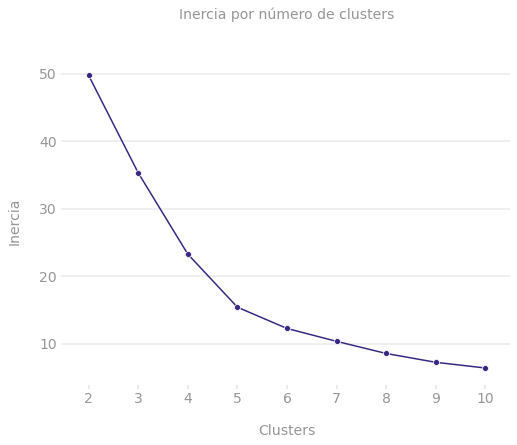

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=k_list, y=inertia, marker='o')
plt.xlim(min(k_list) - max(k_list) * 0.05, max(k_list) * 1.05)
plt.ylim(min(inertia) - max(inertia) * 0.05, max(inertia) * 1.05)
plt.xlabel('Clusters')
plt.ylabel('Inercia')
plt.title('Inercia por número de clusters')
plt.show()

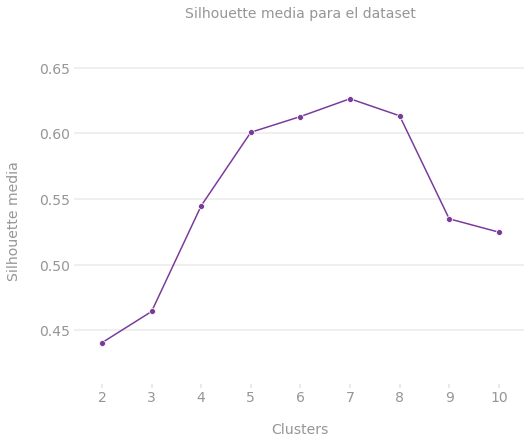

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=k_list, y=sil, marker='o', color=palette[1])
plt.xlim(min(k_list) - max(k_list) * 0.05, max(k_list) * 1.05)
plt.ylim(min(sil) - max(sil) * 0.05, max(sil) * 1.05)
plt.xlabel('Clusters')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para el dataset')
plt.show()

Según el gráfico de codo de la inercia el mejor número sería 5 clusters. Pero, por otro lado, según el gráfico de silhouette el k ideal sería 7. 

Visualizemos las siluetas de los clusters con k entre 5 y 7:

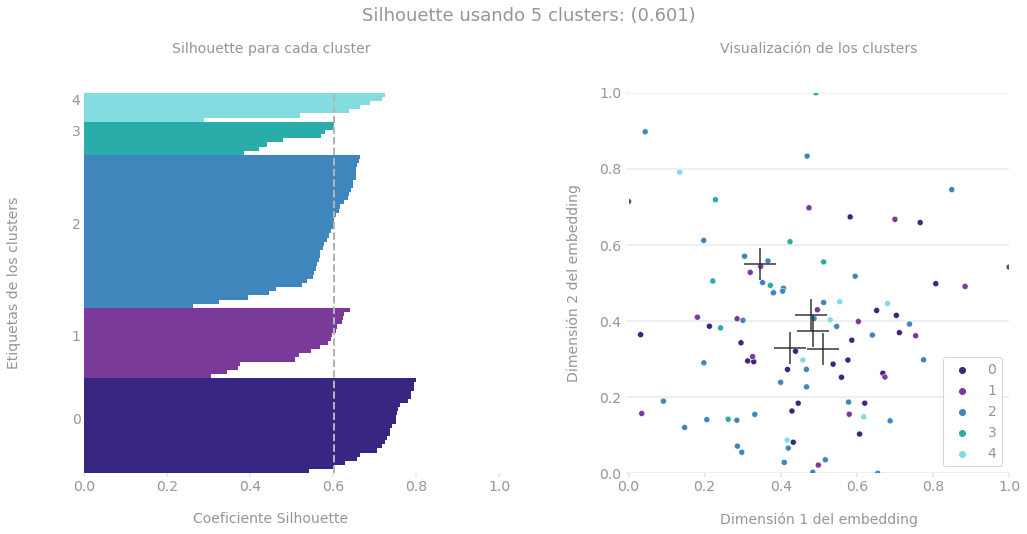

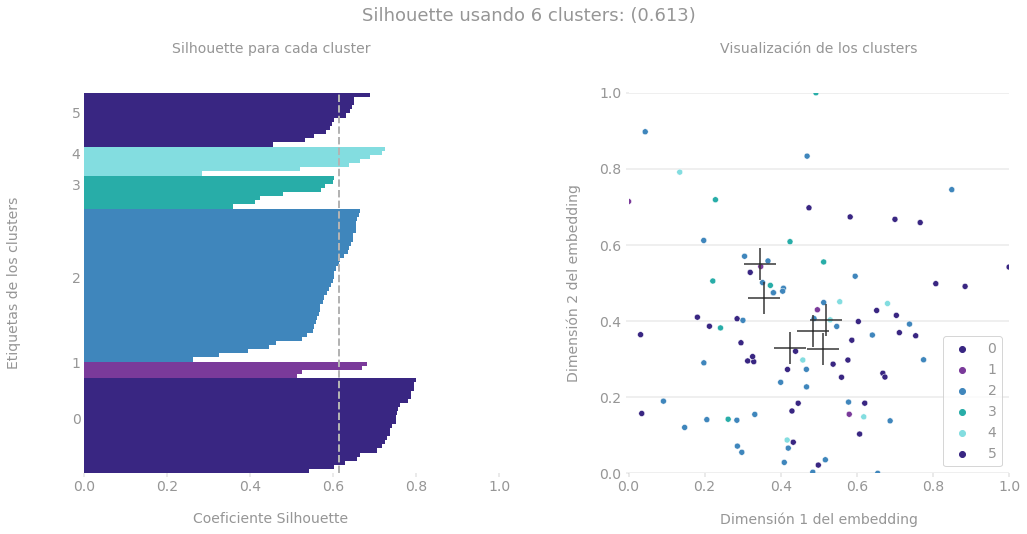

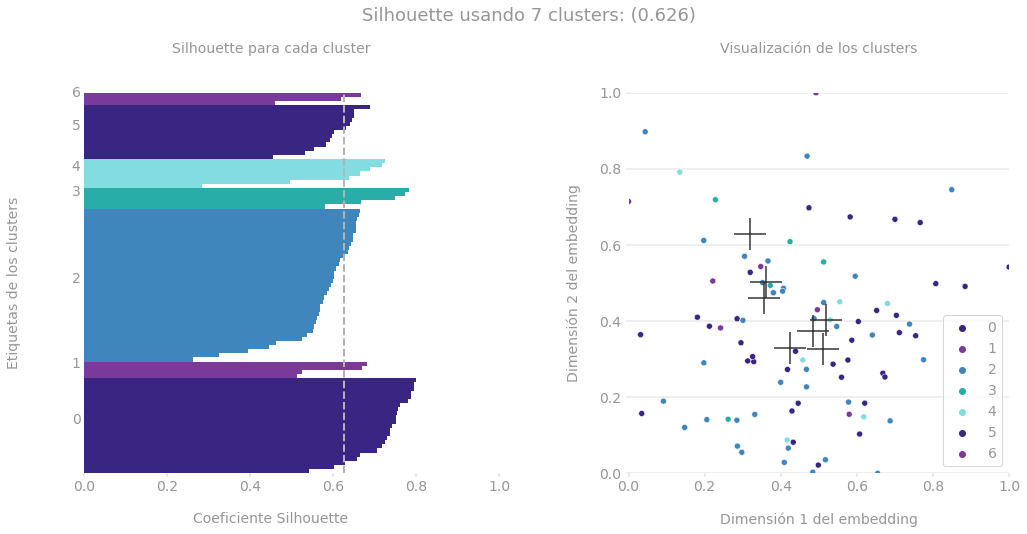

In [ ]:
X_std = df_lyrics_pre_scaled
k_list = [5, 6, 7]

for i, k in enumerate(k_list):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)
    silho_score = silhouette_score(X_std, km.labels_)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper),
                 cluster_silhouette_vals,
                 edgecolor='none',
                 height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='0.7')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1.0])
    ax1.set_xlabel('Coeficiente Silhouette')
    ax1.set_ylabel('Etiquetas de los clusters')
    ax1.set_title('Silhouette para cada cluster', y=1.00)

    # Scatter plot of data colored with labels
    sns.scatterplot(x=X_std.iloc[:, 0], 
                    y=X_std.iloc[:, 1], 
                    hue=labels, 
                    palette=(palette*2)[:k], 
                    ax=ax2)
    ax2.scatter(centroids[:, 0], 
                centroids[:, 1], 
                marker='+', 
                c='0.2', 
                s=1000)

    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Dimensión 1 del embedding')
    ax2.set_ylabel('Dimensión 2 del embedding')
    ax2.set_title('Visualización de los clusters', y=1.00)
    ax2.set_aspect('equal')
    plt.suptitle(f'Silhouette usando {k} clusters: ({silho_score:.3f})',
                 fontsize=18,
                 fontweight=550,
                 y=1.05)
    plt.show()

El número de clusters que elegimos es 5 puesto que un número razonablemente pequeño y la diferente de ```silhouette score``` entre los tres k es más bien mínima.

In [ ]:
lyrics_clustering = KMeans(n_clusters=5, random_state=0)
lyrics_clustering.fit(df_lyrics_pre_scaled)
lyrics_clusters = lyrics_clustering.labels_

### Clusters del audio 🎷

In [ ]:
features_audio = [
    # Medidas de confianza
    #"acousticness",
    #"liveness",
    #"speechiness", 
    #"instrumentalness",

    # Medidas perceptivas
    "energy",
    #"loudness",
    "danceability",
    "valence", 

    # Descriptores músicales
    #"key", 
    #"mode", 
    "tempo"
]

df_audio = df_songs[features_audio].copy()

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
pca_audio = pca.fit_transform(df_audio)

#df_audio = pd.DataFrame(data=pca_audio, columns=list(range(n_components)))

In [ ]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(df_audio.values)
df_audio_scaled = pd.DataFrame(x_scaled, columns=df_audio.columns)

In [ ]:
inertia = []
sil = []
k_list = range(2, 11)
for k in k_list:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(df_audio_scaled)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(df_audio_scaled, km.labels_))

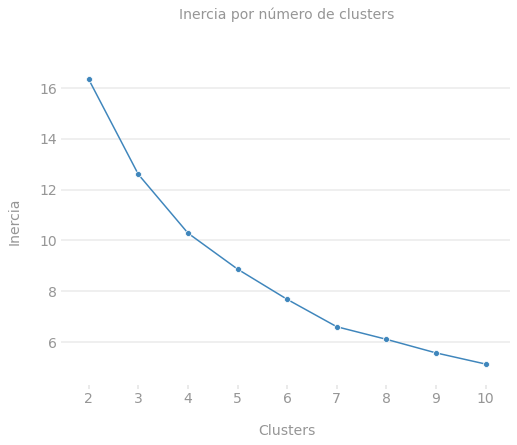

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=k_list, y=inertia, marker='o', color=palette[2])
plt.xlim(min(k_list) - max(k_list) * 0.05, max(k_list) * 1.05)
plt.ylim(min(inertia) - max(inertia) * 0.05, max(inertia) * 1.05)
plt.xlabel('Clusters')
plt.ylabel('Inercia')
plt.title('Inercia por número de clusters')
plt.show()

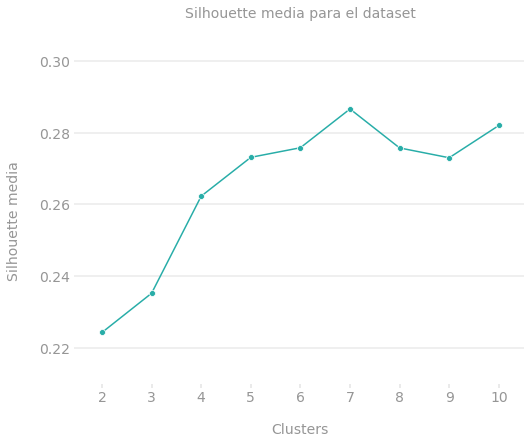

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=k_list, y=sil, marker='o', color=palette[3])
plt.xlim(min(k_list) - max(k_list) * 0.05, max(k_list) * 1.05)
plt.ylim(min(sil) - max(sil) * 0.05, max(sil) * 1.05)
plt.xlabel('Clusters')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para el dataset')
plt.show()

Aquí el mejor número de clusters es bastante subjetivo, por lo que escogeremos 3. 

In [ ]:
audio_clustering = KMeans(n_clusters=4, random_state=0)
audio_clustering.fit(df_audio_scaled)
audio_clusters = audio_clustering.labels_

## Resultados 🐰

### Clusters por separado 🎶

In [ ]:
df_songs[['sentiment', 'emotion']] = df_lyrics[['sentiment', 'emotion']]
df_songs['audio_clusters'] = audio_clusters
df_songs['lyrics_clusters'] = lyrics_clusters

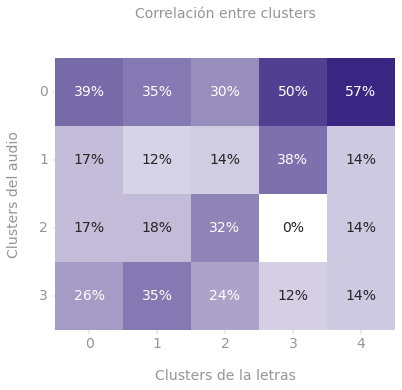

In [ ]:
crosstab = pd.crosstab(df_songs['audio_clusters'], 
                       df_songs['lyrics_clusters'],
                       normalize='columns')

plt.figure(figsize=(8, 5))
sns.heatmap(
    data=crosstab, 
    cbar=False, 
    square=True, 
    annot=True, 
    fmt= '.0%', 
    annot_kws={'size': 14}, 
    xticklabels=crosstab.columns, 
    yticklabels=crosstab.index,
    vmin=0, 
    vmax=None, 
    cmap=LinearSegmentedColormap.from_list('cmap', [
        '#ffffff',
        palette[0]
    ], N=256, gamma=1.0)
)
plt.title('Correlación entre clusters')
plt.xlabel('Clusters de la letras')
plt.ylabel('Clusters del audio')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

Examinamos los géneros de las canciones de los 3 clusters

In [ ]:
for c_audio in range(df_songs.audio_clusters.max()+1):
    cluster = df_songs.query('audio_clusters==@c_audio')
    print(f'Cluster {c_audio} de audio')
    print(f'\tEnergía: {cluster.energy.mean():.2f} (+/-{cluster.energy.std():.2f})')
    print(f'\tTempo: {cluster.tempo.mean():.2f} (+/-{cluster.tempo.std():.2f})')
    print(f'\tBailabilidad: {cluster.danceability.mean():.2f} (+/-{cluster.danceability.std():.2f})')
    print(f'\tValencia: {cluster.valence.mean():.2f} (+/-{cluster.valence.std():.2f})\n')

Cluster 0 de audio
	Energía: 0.59 (+/-0.10)
	Tempo: 102.21 (+/-16.80)
	Bailabilidad: 0.75 (+/-0.11)
	Valencia: 0.32 (+/-0.14)

Cluster 1 de audio
	Energía: 0.62 (+/-0.11)
	Tempo: 172.30 (+/-14.89)
	Bailabilidad: 0.65 (+/-0.09)
	Valencia: 0.41 (+/-0.20)

Cluster 2 de audio
	Energía: 0.67 (+/-0.10)
	Tempo: 142.35 (+/-16.86)
	Bailabilidad: 0.83 (+/-0.06)
	Valencia: 0.72 (+/-0.16)

Cluster 3 de audio
	Energía: 0.78 (+/-0.07)
	Tempo: 95.64 (+/-13.68)
	Bailabilidad: 0.74 (+/-0.10)
	Valencia: 0.66 (+/-0.15)



In [ ]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.append('yeah')

for c_lyric in range(df_songs.lyrics_clusters.max()+1):
    cluster = df_songs.query('lyrics_clusters==@c_lyric')
    all_words = nltk.tokenize.word_tokenize(
        ' '.join(list(cluster.lyrics_clean.str.lower())))
    all_words_dist = nltk.FreqDist(
        w.lower() for w in all_words
        if (w not in stopwords) and (len(w) > 3))
    most_common = [x[0] for x in all_words_dist.most_common(10)]
    print(f'Cluster {c_lyric} de la letra')
    print(f'\tCanciones explicitas: {cluster.song_is_explicit.mean():.0%}')
    print(f'\tSentimiento POS: {cluster.sentiment.mean():.3f} (+/-{cluster.sentiment.std():.3f})')
    print(f'\tEmoción: {cluster.emotion.mode()[0]}')
    print(f'\tKeywords: {", ".join(most_common)}\n')       


Cluster 0 de la letra
	Canciones explicitas: 100%
	Sentimiento POS: 0.034 (+/-0.027)
	Emoción: joy
	Keywords: siempre, baby, noche, quiero, sabe, quiere, ahora, nunca, romperla, conmigo

Cluster 1 de la letra
	Canciones explicitas: 76%
	Sentimiento POS: 0.018 (+/-0.014)
	Emoción: anger
	Keywords: rico, cabrón, puerto, gusta, chocha, ahora, quiero, odio, ¿qué, quiere

Cluster 2 de la letra
	Canciones explicitas: 0%
	Sentimiento POS: 0.120 (+/-0.210)
	Emoción: joy
	Keywords: bien, quiero, dime, party, baby, dale, sale, mami, vida, siempre

Cluster 3 de la letra
	Canciones explicitas: 62%
	Sentimiento POS: 0.012 (+/-0.007)
	Emoción: sadness
	Keywords: noche, dime, tiempo, dejaste, amor, baby, quiere, dónde, dando, encima

Cluster 4 de la letra
	Canciones explicitas: 86%
	Sentimiento POS: 0.015 (+/-0.006)
	Emoción: surprise
	Keywords: hola, toca, siempre, noche, quiero, casi, ¿quién, olvidó, baby, hace



In [ ]:
for c_audio in range(df_songs.audio_clusters.max()+1):
    for c_lyric in range(df_songs.lyrics_clusters.max()+1):
        print(f'Cluster {c_audio}-{c_lyric}')
        cluster = (
            df_songs.query('audio_clusters==@c_audio & lyrics_clusters==@c_lyric')
            [['song_name', 'song_preview_url']]
        )
        try:
            cluster_sample = cluster.sample(5, random_state=42)
        except:
            cluster_sample = cluster
            
        #display(df_songs.query('audio_clusters == @c')[features_audio].describe())
        for idx, row in cluster_sample.iterrows():
            print(row['song_name'], '==>', row['song_preview_url'])
        print('-' * 100)

Cluster 0-0
Ser Bichote ==> https://p.scdn.co/mp3-preview/f6851064dd0f12a01f7c186e0b0c59d3873c032d?cid=15500ca1388444ff91e425a3e0815156
La Corriente ==> https://p.scdn.co/mp3-preview/5b652748ee9a5a10433e28fa0f63f365b8bf58c2?cid=15500ca1388444ff91e425a3e0815156
200 Mph ==> https://p.scdn.co/mp3-preview/5bc2bc152f29a7879772fc8c3e50402478a99464?cid=15500ca1388444ff91e425a3e0815156
Yo No Soy Celoso ==> https://p.scdn.co/mp3-preview/8b867e2dbbeb7af42c1efbc76d29d186a8ca4a61?cid=15500ca1388444ff91e425a3e0815156
Solo de Mi ==> https://p.scdn.co/mp3-preview/f7e44d65287ea4ce95f36fb99cd93964a49f2fe5?cid=15500ca1388444ff91e425a3e0815156
----------------------------------------------------------------------------------------------------
Cluster 0-1
Está Cabrón Ser Yo ==> https://p.scdn.co/mp3-preview/0859f08bb1b6a80c229ae4930b105ce262da94f7?cid=15500ca1388444ff91e425a3e0815156
Tenemos Que Hablar ==> https://p.scdn.co/mp3-preview/558e92a5b765d4fe61f598905883c096cfb290ef?cid=15500ca1388444ff91e425a3e

### Clusters completo 🎵
Si bien al hacer clústeres por separado se notan algunos grupos interesantes, el problema reside en que hay demasiados y caracterizarlos todos se vuelve complicado. Por tanto, el paso a seguir es probar un solo modelo de clustering que tengan en cuenta todas las características de la canción.

In [ ]:
df_complete = pd.concat([df_audio_scaled, df_lyrics_pre_scaled], axis=1)

In [ ]:
n_components = 4
pca = PCA(n_components=n_components)
pca_complete = pca.fit_transform(df_complete)

In [ ]:
inertia = []
sil = []
k_list = range(2, 11)
for k in k_list:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(pca_complete)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(pca_complete, km.labels_))

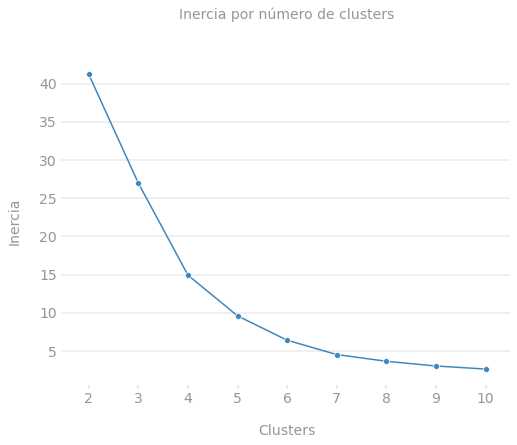

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=k_list, y=inertia, marker='o', color=palette[2])
plt.xlim(min(k_list) - max(k_list) * 0.05, max(k_list) * 1.05)
plt.ylim(min(inertia) - max(inertia) * 0.05, max(inertia) * 1.05)
plt.xlabel('Clusters')
plt.ylabel('Inercia')
plt.title('Inercia por número de clusters')
plt.show()

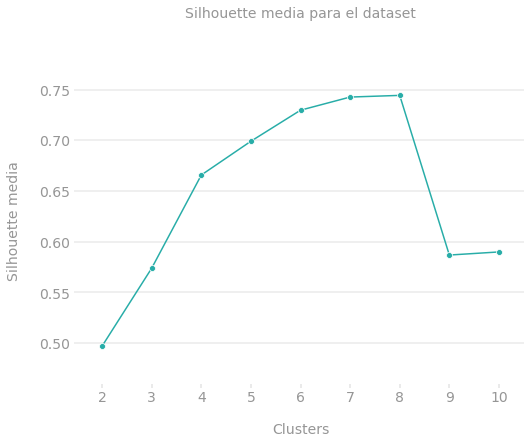

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=k_list, y=sil, marker='o', color=palette[3])
plt.xlim(min(k_list) - max(k_list) * 0.05, max(k_list) * 1.05)
plt.ylim(min(sil) - max(sil) * 0.05, max(sil) * 1.05)
plt.xlabel('Clusters')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para el dataset')
plt.show()

Para mantener la simpleza solo trabajaremos con 4 clusters e intentaremos identificar qué tienen en común estas canciones.

In [ ]:
k_full = 4
km = KMeans(n_clusters=k_full, random_state=0)
km.fit(pca_complete)
full_clusters = km.labels_

In [ ]:
df_songs['full_clusters'] = full_clusters

In [ ]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.append('yeah')

for c_full in range(df_songs.full_clusters.max()+1):
    cluster = df_songs.query('full_clusters==@c_full')
    all_words = nltk.tokenize.word_tokenize(
        ' '.join(list(cluster.lyrics_clean.str.lower())))
    all_words_dist = nltk.FreqDist(
        w.lower() for w in all_words
        if (w not in stopwords) and (len(w) > 3))
    most_common = [x[0] for x in all_words_dist.most_common(10)]
    print(f'Cluster {c_full}')
    print(f'\tNúmero de canciones: {len(cluster)}')
    print(f'\tCanciones explicitas: {cluster.song_is_explicit.mean():.0%}')
    print(f'\tSentimiento POS: {cluster.sentiment.mean():.3f}')
    print(f'\tEmoción: {cluster.emotion.mode()[0]}')
    print(f'\tEnergía: {cluster.energy.mean():.2f}')
    print(f'\tTempo: {cluster.tempo.mean():.2f}')
    print(f'\tBailabilidad: {cluster.danceability.mean():.2f}')
    print(f'\tValencia: {cluster.valence.mean():.2f}')
    print(f'\tKeywords: {", ".join(most_common)}')
    print(f'\tAlbum: {cluster.album_name.mode()[0]}')      
    print(f'\tEjemplares:') 
    try:
        cluster_sample = cluster.sample(10, random_state=42)
    except:
        cluster_sample = cluster
    finally:
        for idx, row in cluster_sample.iterrows():
            print(f'\t\t{row["song_name"]} ==> {row["song_preview_url"]}')
        print('-'*150)

Cluster 0
	Número de canciones: 23
	Canciones explicitas: 100%
	Sentimiento POS: 0.034
	Emoción: joy
	Energía: 0.67
	Tempo: 121.29
	Bailabilidad: 0.75
	Valencia: 0.49
	Keywords: siempre, baby, noche, quiero, sabe, quiere, ahora, nunca, romperla, conmigo
	Album: X 100PRE
	Ejemplares:
		P FKN R ==> https://p.scdn.co/mp3-preview/608f3e482c7505a9c6519c93669da272a54fb1ae?cid=15500ca1388444ff91e425a3e0815156
		PA' ROMPERLA ==> https://p.scdn.co/mp3-preview/acbeb16d2a372881639cfe7f6eef580ffba8cb11?cid=15500ca1388444ff91e425a3e0815156
		Moscow Mule ==> https://p.scdn.co/mp3-preview/585736d2d4dba1eef13b6d63c54dd4c16a3275fb?cid=15500ca1388444ff91e425a3e0815156
		CANCIÓN CON YANDEL ==> https://p.scdn.co/mp3-preview/502b2bbed9899250999344041c0f06385f0366da?cid=15500ca1388444ff91e425a3e0815156
		200 Mph ==> https://p.scdn.co/mp3-preview/5bc2bc152f29a7879772fc8c3e50402478a99464?cid=15500ca1388444ff91e425a3e0815156
		La Zona ==> https://p.scdn.co/mp3-preview/0a5f12b0730a2ab2f2b1edb6cadcffa1215b9017?c

Al ver las estadísticas y revisar las canciones de cada grupo, hemos podido identificar los clusters de la siguiente manera:

- ```Cluster 00``` **— Benito Bellacoso**: Son canciones de reggaeton enérgicas, movidas y a menudo explícitas.

- ```Cluster 01``` **— Benito Bichote**: Son canciones usualmente de trap/rap sobre orgullo, amor propio y empoderamiento.

- ```Cluster 02``` **— Benito PG-13**: Son canciones más family-friendly y comerciales, los géneros son variados.

- ```Cluster 03``` **— Benito Sad**: Son canciones de trap negativas y meláncolicas, la temática principal son desaromes y nostalgia por personas que ya no están. 

![clusters](https://i.imgur.com/ef0nQ50.png)

## Siguientes pasos ⏩

Consideramos que el siguiente paso sería disponibilizar este agrupamiento en un dashboard público en [Streamlit](https://streamlit.io/gallery) donde las personas puedan seleccionar clusters y que el sistema cree playlists automáticamente en sus cuentas de Spotify.

## Referencias 🔍 
- https://towardsdatascience.com/machine-learning-and-recommender-systems-using-your-own-spotify-data-4918d80632e3
- https://chrishyland.github.io/scraping-from-genius/


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eb02c87d-b537-48b1-9a25-eb017d0bc84f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>